In [1]:
#Importing the necessary libraries:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
from datetime import datetime
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import shap

%matplotlib inline


In [2]:
df=pd.read_csv("breast-cancer-wisconsin-data.csv")
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [3]:
df['diagnosis_numeric'] = df['diagnosis'].map({'M': 1, 'B': 0})

In [4]:
# Split the dataset into features and target
X = df.drop(columns=['diagnosis', 'id','diagnosis_numeric'])  # Exclude the target column and id column
y = df['diagnosis_numeric']

# Split the data (assuming 'X' as features and 'y' as target variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]  # For ROC/AUC

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC AUC Score: {roc_auc:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


Confusion Matrix:
[[69  2]
 [ 3 40]]

ROC AUC Score: 0.9908


In [6]:
# Feature Selection with SelectKBest (using mutual information classification score)
selector = SelectKBest(score_func=mutual_info_classif, k=20)  # You can change 'k' to select top k features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit the model
xgb_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_selected)
y_pred_prob = xgb_model.predict_proba(X_test_selected)[:, 1]  # For ROC/AUC

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC AUC Score: {roc_auc:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


Confusion Matrix:
[[69  2]
 [ 3 40]]

ROC AUC Score: 0.9941


In [7]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}


# Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy',  # Change to 'recall' or 'roc_auc' if desired
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Best parameters and model evaluation
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Evaluate the optimized model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nOptimized ROC AUC Score: {roc_auc:.4f}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.6}

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


Confusion Matrix:
[[70  1]
 [ 2 41]]

Optimized ROC AUC Score: 0.9905


In [8]:
# Feature Selection with SelectKBest (using mutual information classification score)
selector = SelectKBest(score_func=mutual_info_classif, k=12)  # You can change 'k' to select top k features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)


# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,
                         max_depth=5, n_estimator=200, subsample=0.6,
                         learning_rate=0.2, colsample_bytree=0.6, class_weight='balanced')

# Fit the model
xgb_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_selected)
y_pred_prob = xgb_model.predict_proba(X_test_selected)[:, 1]  # For ROC/AUC

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC AUC Score: {roc_auc:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        71
           1       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114


Confusion Matrix:
[[69  2]
 [ 2 41]]

ROC AUC Score: 0.9957


/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:36:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight", "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


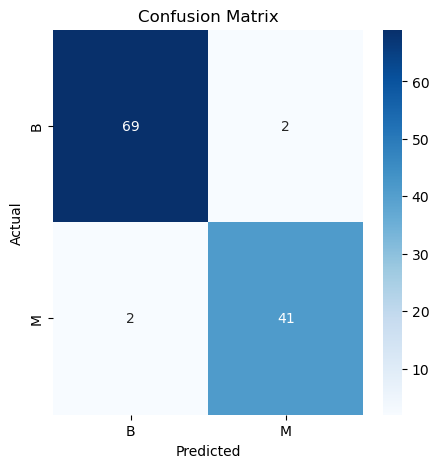

In [12]:
### Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<Figure size 1000x800 with 0 Axes>

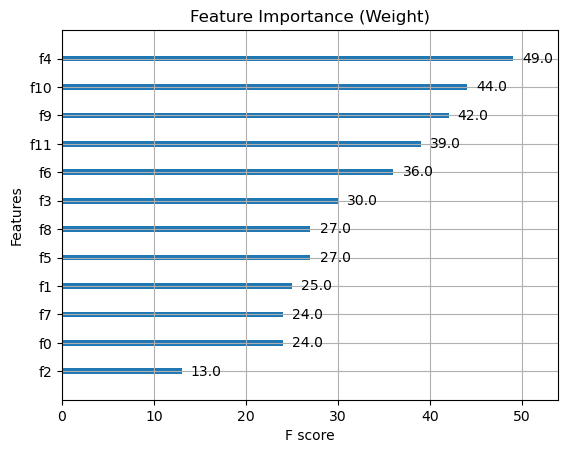

In [9]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, importance_type='weight')  # Options: 'weight', 'gain', 'cover'
plt.title("Feature Importance (Weight)")
plt.show()

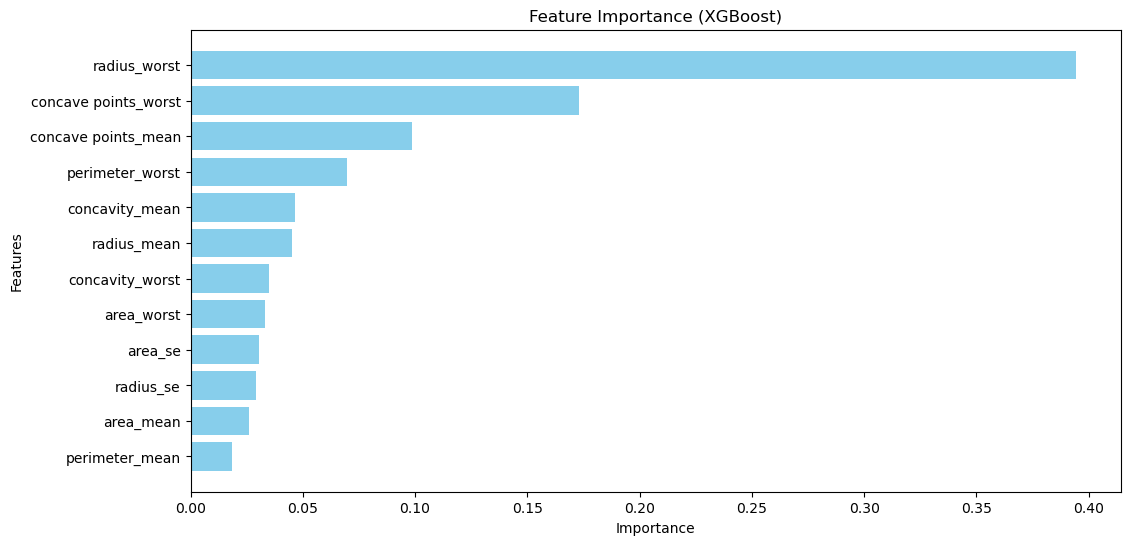

In [10]:
selected_feature_indices = selector.get_support(indices=True) 
selected_feature_names = X_test.columns[selected_feature_indices]
# Extract feature importance
feature_importance = pd.DataFrame({
    'Feature': selected_feature_names,  # Replace X.columns with actual feature names if needed
    'Importance': xgb_model.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # Reverse the order for better readability
plt.show()


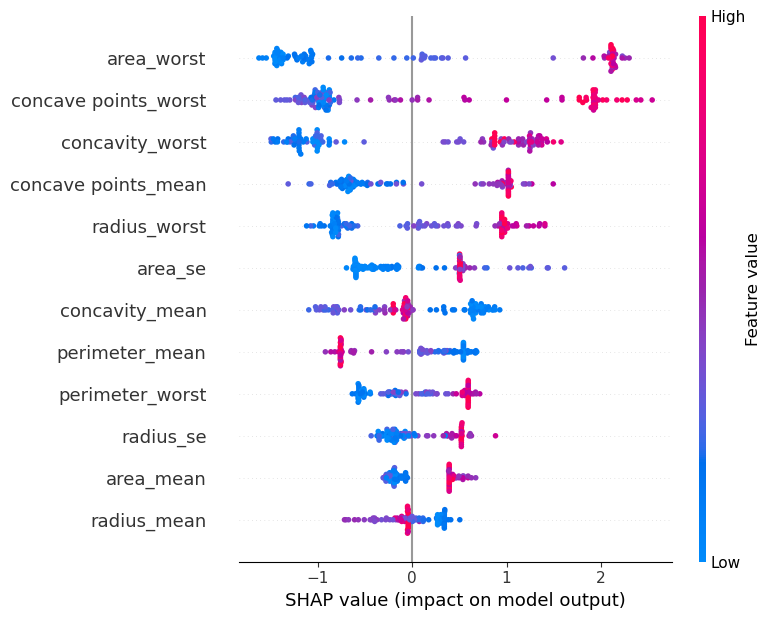

In [208]:
# Explain the model's predictions
explainer = shap.Explainer(xgb_model, X_test_selected)
shap_values = explainer(X_test_selected)

# Summary plot of feature importance
shap.summary_plot(shap_values, X_test_selected, feature_names=X_test.columns[selected_feature_indices])

### Feature Importance (Top to Bottom):
Features are ordered by their importance. The most impactful features are at the top.
For example, area_worst has the highest impact on model predictions, followed by concave points_worst, concavity_worst, and so on.

SHAP Values (Left to Right): The x-axis represents the SHAP value, which indicates the direction and magnitude of a feature's contribution to the prediction: Negative SHAP values (< 0): The feature pushes the prediction towards class B (or the negative class in your dataset). Positive SHAP values (> 0): The feature pushes the prediction towards class M (or the positive class in your dataset).

For example, area_worst has high positive SHAP values (to the right) for some samples, strongly contributing to class M, and low SHAP values (to the left) for class B. Feature Value Color (Red/Blue): The color indicates the feature's value: Red: High feature value. Blue: Low feature value.

For instance:
For area_worst, high feature values (red) tend to push the prediction toward class M (positive SHAP values). Conversely, low values (blue) push the prediction towards class B. Spread and Distribution: The spread of SHAP values for each feature shows its variability across samples. Features like area_worst and concave points_worst have a wide spread, meaning they have a significant and varied impact on predictions for different samples. Features with smaller spreads, like radius_mean, have less variability and overall impact.

In [13]:
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_feature_names)
# Combine X_test_selected_df and y_test for easier analysis
X_test_with_labels = pd.concat([X_test_selected_df.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

# Rename target column for clarity (optional)
X_test_with_labels.rename(columns={0: 'True Label'}, inplace=True)

# Add predictions and predicted probabilities
X_test_with_labels['Predicted Label'] = y_pred
X_test_with_labels['Predicted Probability'] = y_pred_prob  # Assuming positive class at index 1

# Find misclassified samples
errors = X_test_with_labels[X_test_with_labels['diagnosis_numeric'] != X_test_with_labels['Predicted Label']]

print(errors)

     radius_mean  perimeter_mean  area_mean  concavity_mean  \
8          13.34           86.49      520.0         0.11690   
20         13.80           90.43      584.1         0.07789   
82         14.48           94.25      648.2         0.12040   
108        14.44           93.97      640.1         0.08487   

     concave points_mean  radius_se  area_se  radius_worst  perimeter_worst  \
8                0.06987     0.2860    12.96         15.53            96.66   
20               0.05069     0.2787    23.35         16.57           110.30   
82               0.04938     0.4204    38.87         16.21           108.40   
108              0.05532     0.2406    21.20         15.85           108.60   

     area_worst  concavity_worst  concave points_worst  diagnosis_numeric  \
8         614.9           0.4858                0.1708                  0   
20        812.4           0.2779                0.1383                  1   
82        808.9           0.3349                0.1225   

In [14]:
# Create 'errors' column: 1 if there is an error (i.e., 'diagnosis' != 'Predicted Label'), else 0
X_test_with_labels['errors'] = np.where(X_test_with_labels['diagnosis_numeric'] != X_test_with_labels['Predicted Label'], 1, 0)

# View the updated DataFrame
X_test_with_labels

,radius_mean,perimeter_mean,area_mean,concavity_mean,concave points_mean,radius_se,area_se,radius_worst,perimeter_worst,area_worst,concavity_worst,concave points_worst,diagnosis_numeric,Predicted Label,Predicted Probability,errors
0,12.47,81.09,481.9,0.08005,0.03821,0.3961,30.29,14.97,96.05,677.9,0.2671,0.10150,0,0,0.006187,0
1,18.94,123.60,1130.0,0.10800,0.07951,0.7888,96.05,24.86,165.90,1866.0,0.2687,0.17890,1,1,0.998949,0
2,15.46,101.70,748.9,0.14660,0.08087,0.4743,48.31,19.26,124.90,1156.0,0.3791,0.15140,1,1,0.998840,0
3,12.40,81.47,467.8,0.07741,0.02799,0.1767,15.43,12.88,89.61,515.8,0.2403,0.07370,0,0,0.002294,0
4,11.54,74.65,402.9,0.06737,0.02594,0.2784,20.86,12.26,78.78,457.8,0.1797,0.06918,0,0,0.000595,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,14.64,94.21,666.0,0.05192,0.02791,0.2204,19.98,16.46,106.00,831.0,0.2437,0.07828,0,0,0.028548,0
110,16.07,104.10,817.7,0.09769,0.06638,0.7474,79.25,19.77,128.80,1223.0,0.2829,0.15200,1,1,0.998847,0
111,11.52,73.87,406.3,0.04328,0.02929,0.2562,18.62,12.65,80.88,491.8,0.1804,0.09608,0,0,0.001592,0
112,14.22,92.55,623.9,0.11030,0.04408,0.3354,29.96,15.75,102.50,764.0,0.3064,0.08219,0,0,0.018915,0


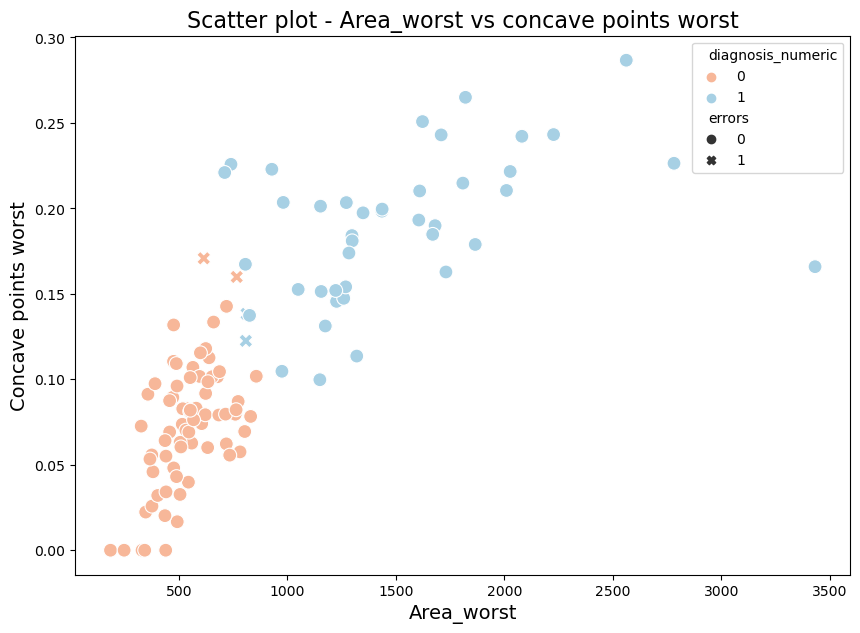

In [19]:
### Scatter plot between concave points_worst and perimeter_mean

fig=plt.figure(figsize=(10,7))
sns.scatterplot(data=X_test_with_labels, x='area_worst',y='concave points_worst', palette='RdBu', hue='diagnosis_numeric', style='errors', s=100)
plt.title('Scatter plot - Area_worst vs concave points worst', fontsize=16)
plt.xlabel('Area_worst', fontsize=14)
plt.ylabel('Concave points worst', fontsize=14)

plt.show();

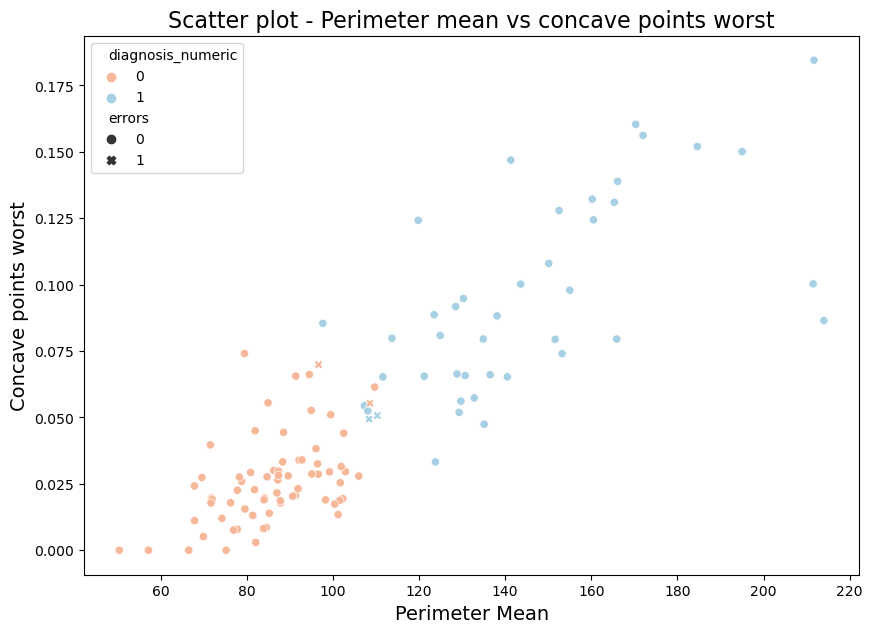

In [212]:
### Scatter plot between concave points_worst and perimeter_mean

fig=plt.figure(figsize=(10,7))
sns.scatterplot(data=X_test_with_labels, x='perimeter_worst',y='concave points_mean', palette='RdBu', hue='diagnosis_numeric', style='errors')
plt.title('Scatter plot - Perimeter mean vs concave points worst', fontsize=16)
plt.xlabel('Perimeter Mean', fontsize=14)
plt.ylabel('Concave points worst', fontsize=14)

plt.show();

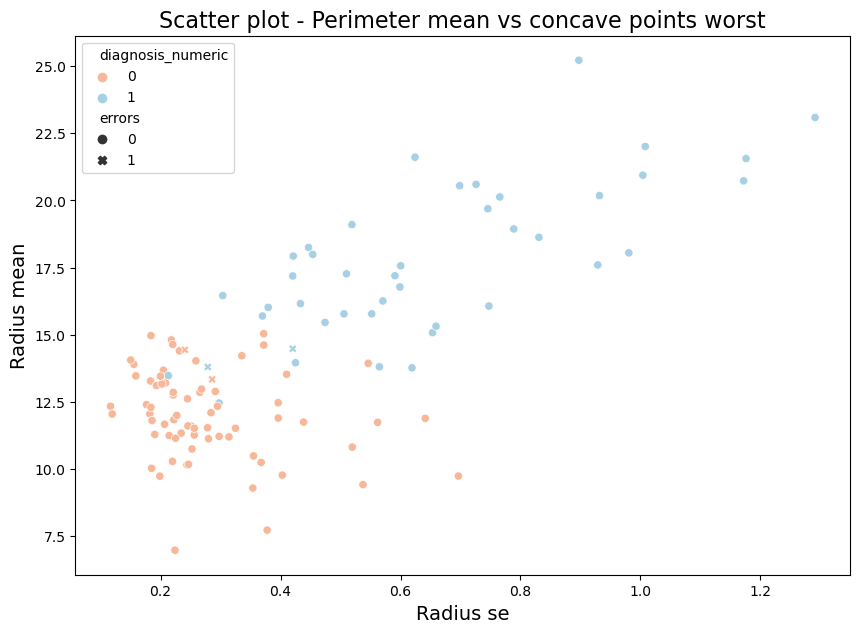

In [213]:
### Scatter plot between concave points_worst and perimeter_mean

fig=plt.figure(figsize=(10,7))
sns.scatterplot(data=X_test_with_labels, x='radius_se',y='radius_mean', palette='RdBu', hue='diagnosis_numeric', style='errors')
plt.title('Scatter plot - Perimeter mean vs concave points worst', fontsize=16)
plt.xlabel('Radius se', fontsize=14)
plt.ylabel('Radius mean', fontsize=14)

plt.show();

In [214]:
errors = X_test_with_labels[X_test_with_labels['errors'] == 1]
errors

,radius_mean,perimeter_mean,area_mean,concavity_mean,concave points_mean,radius_se,area_se,radius_worst,perimeter_worst,area_worst,concavity_worst,concave points_worst,diagnosis_numeric,Predicted Label,Predicted Probability,errors
8,13.34,86.49,520.0,0.11690,0.06987,0.2860,12.96,15.53,96.66,614.9,0.4858,0.1708,0,1,0.894803,1
20,13.80,90.43,584.1,0.07789,0.05069,0.2787,23.35,16.57,110.30,812.4,0.2779,0.1383,1,0,0.216443,1
82,14.48,94.25,648.2,0.12040,0.04938,0.4204,38.87,16.21,108.40,808.9,0.3349,0.1225,1,0,0.371457,1
108,14.44,93.97,640.1,0.08487,0.05532,0.2406,21.20,15.85,108.60,766.9,0.3103,0.1599,0,1,0.953857,1


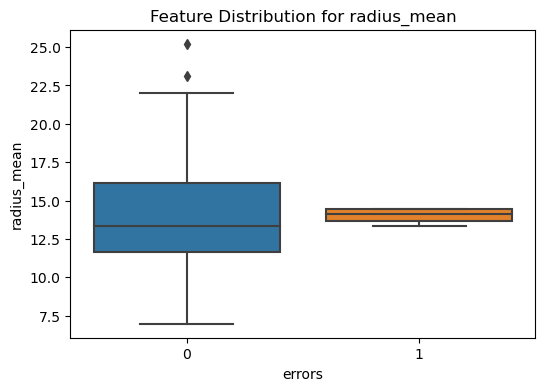

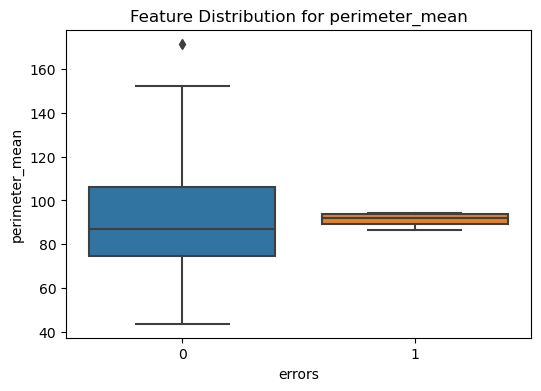

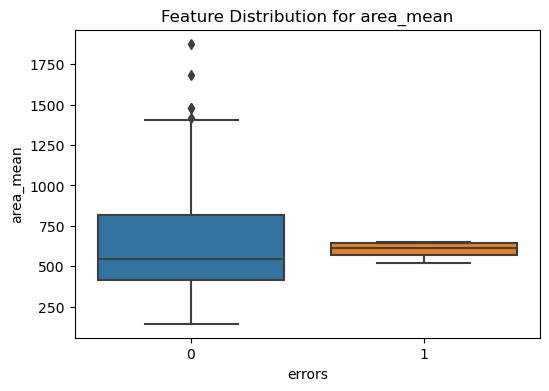

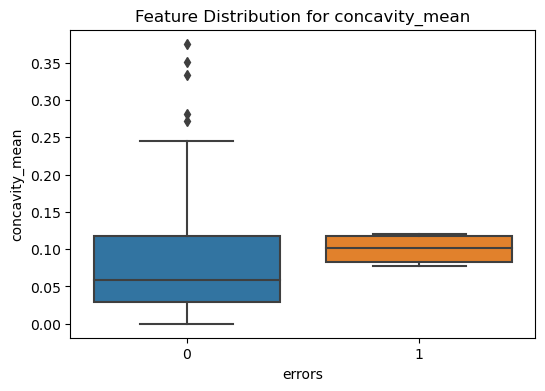

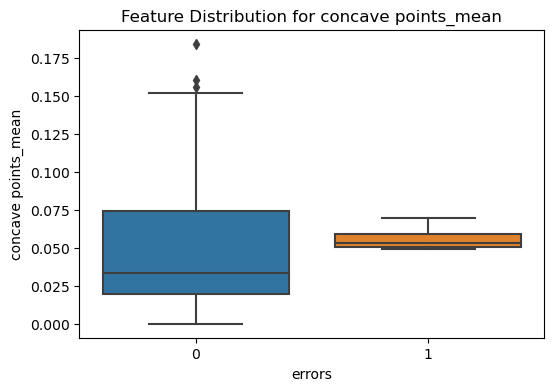

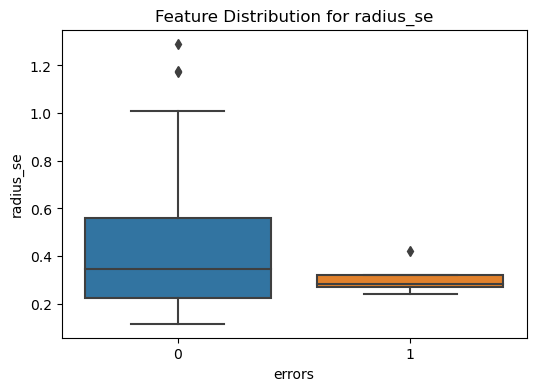

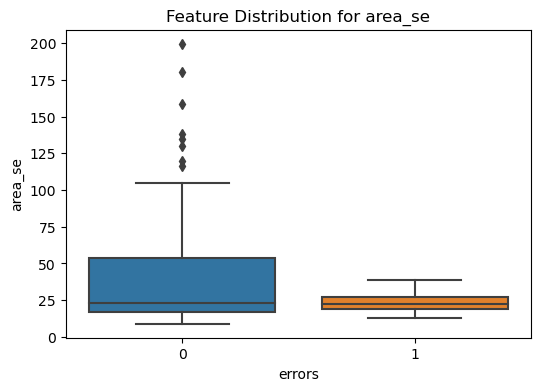

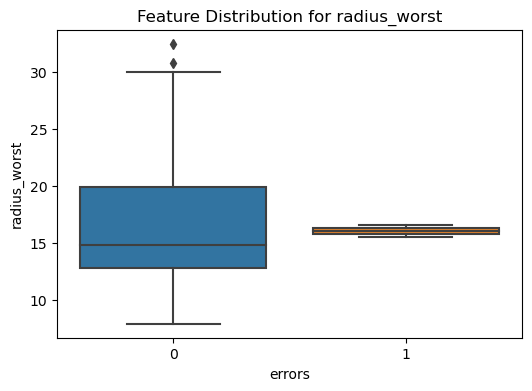

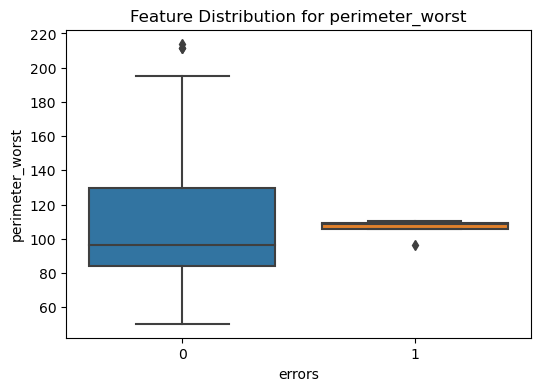

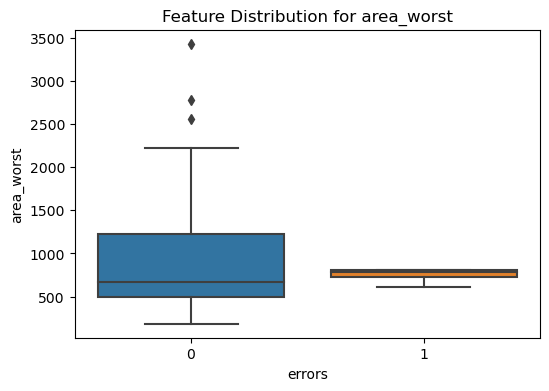

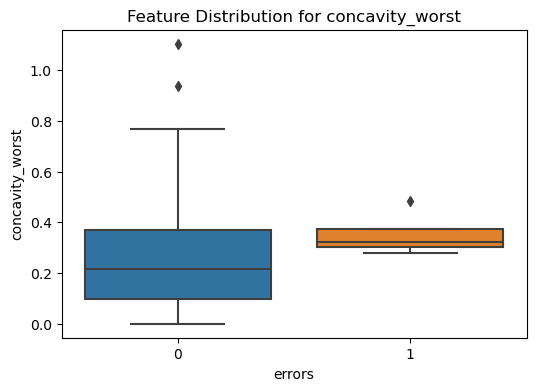

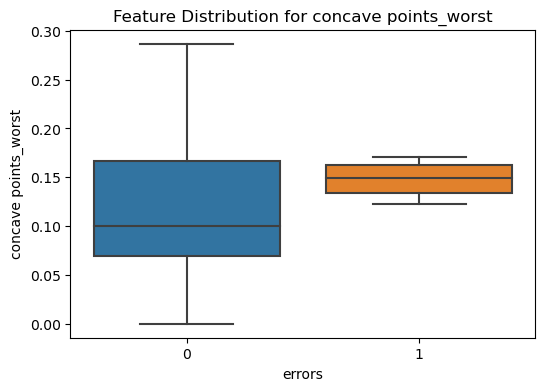

In [215]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in selected_feature_names:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=X_test_with_labels, x='errors', y=feature)
    plt.title(f'Feature Distribution for {feature}')
    plt.show()

Instance 8 - Diagnosis: 0


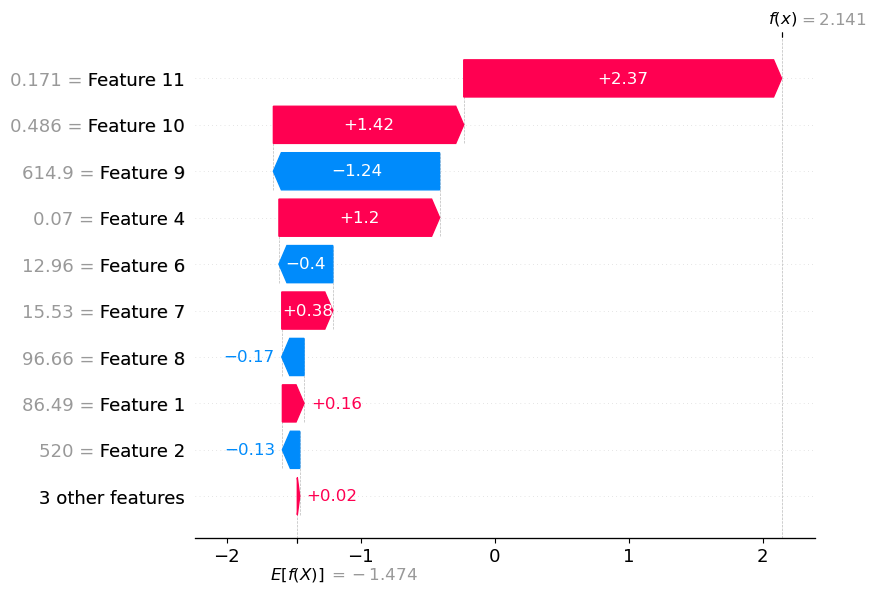

                 Feature  SHAP Value  Feature Value
11  concave points_worst    2.372324        0.17080
10       concavity_worst    1.420827        0.48580
4    concave points_mean    1.199252        0.06987
7           radius_worst    0.381106       15.53000
1         perimeter_mean    0.161715       86.49000
0            radius_mean    0.080109       13.34000
5              radius_se    0.019733        0.28600
3         concavity_mean   -0.081649        0.11690
2              area_mean   -0.129690      520.00000
8        perimeter_worst   -0.166343       96.66000
Instance 20 - Diagnosis: 1


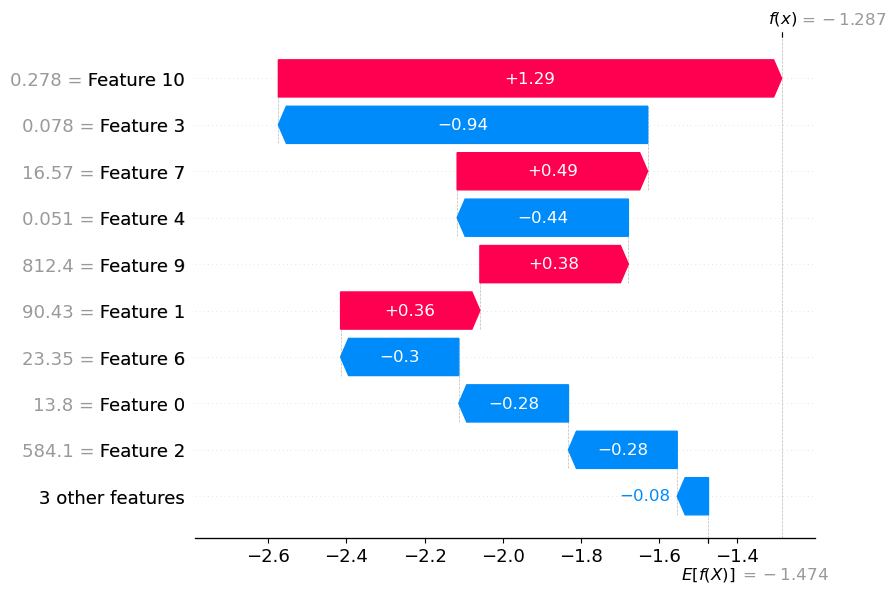

                 Feature  SHAP Value  Feature Value
10       concavity_worst    1.287612         0.2779
7           radius_worst    0.487481        16.5700
9             area_worst    0.379917       812.4000
1         perimeter_mean    0.356406        90.4300
8        perimeter_worst    0.151293       110.3000
5              radius_se   -0.106724         0.2787
11  concave points_worst   -0.124570         0.1383
2              area_mean   -0.278194       584.1000
0            radius_mean   -0.280691        13.8000
6                area_se   -0.302366        23.3500
Instance 82 - Diagnosis: 1


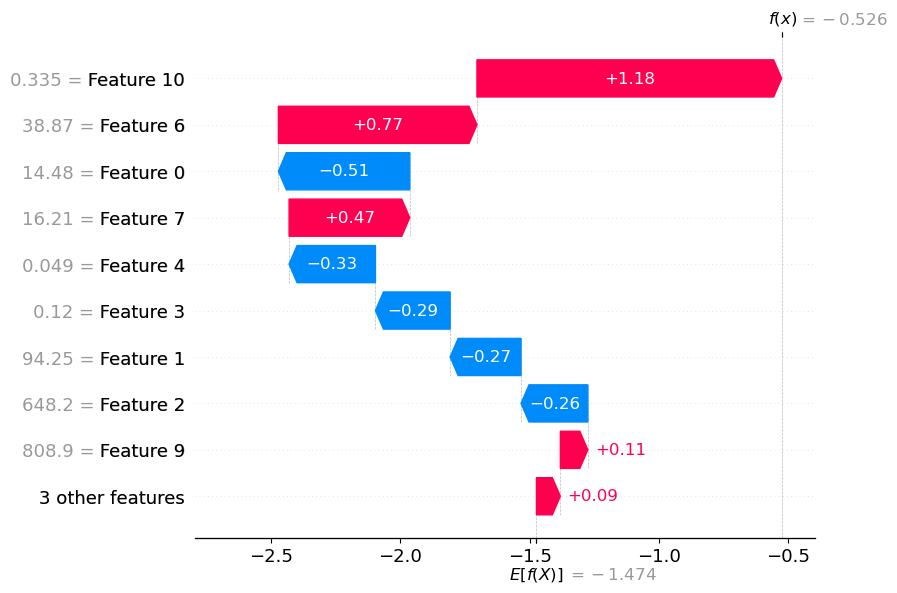

                 Feature  SHAP Value  Feature Value
10       concavity_worst    1.177761         0.3349
6                area_se    0.767600        38.8700
7           radius_worst    0.466467        16.2100
9             area_worst    0.106224       808.9000
8        perimeter_worst    0.067626       108.4000
11  concave points_worst    0.056404         0.1225
5              radius_se   -0.031653         0.4204
2              area_mean   -0.258201       648.2000
1         perimeter_mean   -0.274072        94.2500
3         concavity_mean   -0.288731         0.1204
Instance 108 - Diagnosis: 0


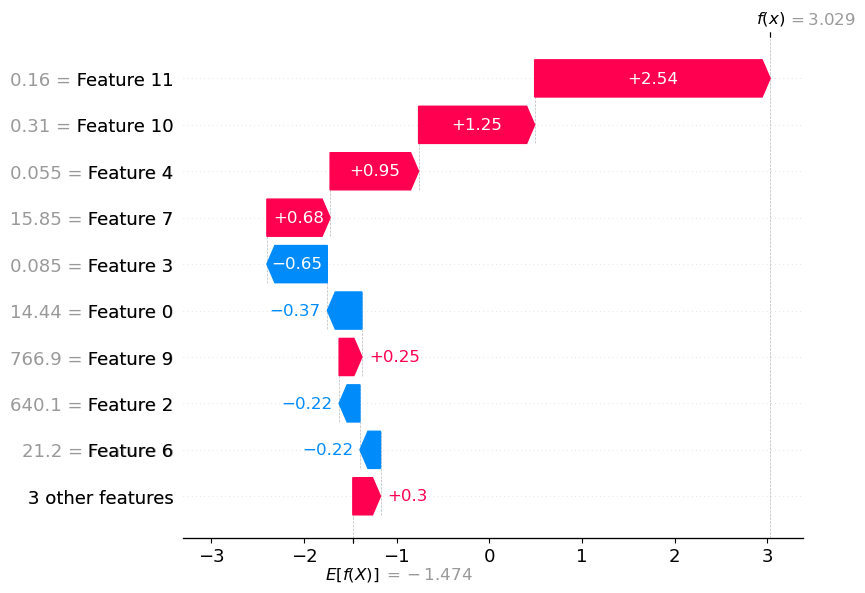

                 Feature  SHAP Value  Feature Value
11  concave points_worst    2.540803        0.15990
10       concavity_worst    1.252301        0.31030
4    concave points_mean    0.954725        0.05532
7           radius_worst    0.682111       15.85000
9             area_worst    0.246007      766.90000
1         perimeter_mean    0.196922       93.97000
8        perimeter_worst    0.140409      108.60000
5              radius_se   -0.038895        0.24060
6                area_se   -0.221594       21.20000
2              area_mean   -0.224875      640.10000


In [216]:
# Ensure X_test_selected is a DataFrame with feature names
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_feature_names)  # Replace `feature_names` with your list
# Iterate over the first 5 errors
for i in errors.index[:5]:  
    print(f"Instance {i} - Diagnosis: {y_test.iloc[i]}")

    # Waterfall plot for the specific instance
    shap.plots.waterfall(shap_values[i])

    # Get feature names for this instance and their SHAP values
    feature_importance = pd.DataFrame({
        "Feature": X_test_selected.columns,
        "SHAP Value": shap_values[i].values,  # SHAP values for instance i
        "Feature Value": X_test_selected.iloc[i].values  # Actual feature values
    })

    # Display feature importance sorted by SHAP value
    print(feature_importance.sort_values(by="SHAP Value", ascending=False).head(10))  # Top 10 features

### Observations
1. Dominant Features for Misclassified Instances

The following features seem to be the most influential across the errors, as they repeatedly have the highest SHAP values (both positive and negative):

concave points_worst: This feature consistently has the highest SHAP value (positive influence) in almost all misclassified instances.
concavity_worst: Another major contributor to misclassification, with high positive SHAP values in the majority of the errors.
radius_worst: Frequently appears with significant SHAP values, positively influencing the predictions for both errors in class 0 and class 1.
area_se and area_mean: These features occasionally contribute to the errors, but their SHAP values are smaller and can be either positive or negative.


### 2. Errors for Class B (Benign)

Instances with Diagnosis B (True Label = 0) and misclassified as Malignant (M):
The SHAP values indicate strong positive influence from features like concave points_worst, concavity_worst, and radius_worst, which are typically higher for malignant cases.
However, the feature values for these instances (e.g., concave points_worst = 0.1599, concavity_worst = 0.3103) are closer to the boundary between benign and malignant cases rather than being extreme. These values are higher than typical benign cases but lower than strongly malignant ones.
This suggests these instances fall in a gray area where their feature values are intermediate, leading to confusion for the model.


### 3. Errors for Class M (Malignant)

Instances with Diagnosis M (True Label = 1) and misclassified as Benign (B):
The SHAP values show negative contributions from features like radius_mean, area_mean, and concavity_mean, which typically have higher values for malignant cases. However, in these misclassified cases, the feature values are lower (closer to benign ranges).
For instance:
Instance 82: concavity_mean = 0.1204 and area_mean = 648.2 are relatively low for malignant cases, pulling the prediction toward benign.
Instance 20: Similar trends with radius_mean = 13.8 and area_mean = 584.1.


### 4. Boundary Nature of Errors

The errors for both classes (B and M) seem to occur in the overlap regions of feature distributions. For example:
For Benign misclassified as Malignant: Features like concave points_worst are slightly elevated but not extreme.
For Malignant misclassified as Benign: Features like concavity_mean or radius_mean are lower than typical malignant cases.
This boundary nature aligns with your earlier observation: the errors lie in the middle of feature distributions, not in the extreme ranges.



### Insights
Key Features for Analysis:
The top features (concave points_worst, concavity_worst, and radius_worst) are critical in driving the misclassifications. Investigating their thresholds (e.g., comparing distributions for true positives vs. errors) might provide insights.
Class-Specific Challenges:
For class B (Benign): Errors occur for cases where key malignant indicators (e.g., concave points_worst) are slightly elevated but not extreme.
For class M (Malignant): Errors occur for cases where key malignant features (e.g., area_mean, concavity_mean) are slightly lower, pulling predictions toward benign.
Model Comparison:
SVC's better handling of false negatives (Malignant classified as Benign) suggests that it may be more robust for critical malignant cases. This aligns with your earlier findings.


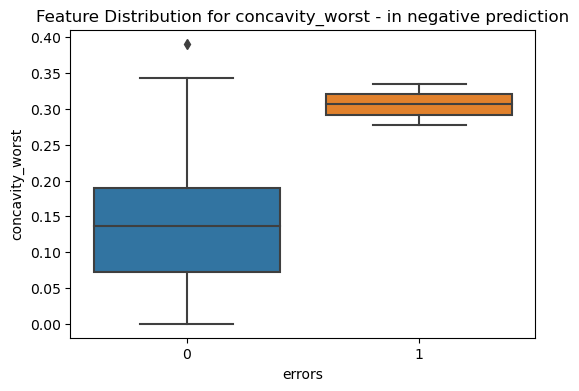

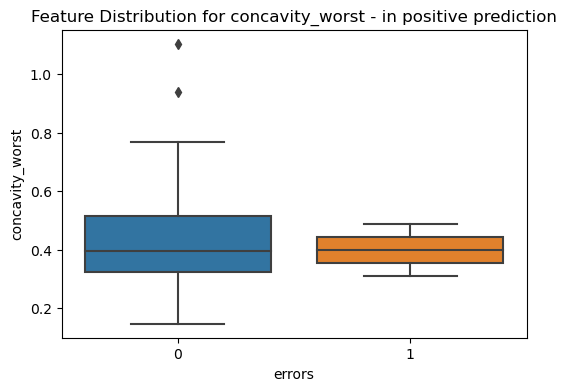

In [217]:
B=X_test_with_labels.loc[X_test_with_labels['Predicted Label']==0]
N=X_test_with_labels.loc[X_test_with_labels['Predicted Label']==1]

plt.figure(figsize=(6, 4))
sns.boxplot(data=B, x='errors', y='concavity_worst')
plt.title(f'Feature Distribution for concavity_worst - in negative prediction')
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=N, x='errors', y='concavity_worst')
plt.title(f'Feature Distribution for concavity_worst - in positive prediction')
plt.show()

### What do we see here: distribution for concavity_worst for Benign (negative) and Malignant (positive) cases, errors in negative class were - that two malignant cases were predicted as benign - but this feature was not the reason; errors in positive class - two benigh were predicted as malignant, and her we see  - because the parameteres of concavity-worst are as for malignant samples.

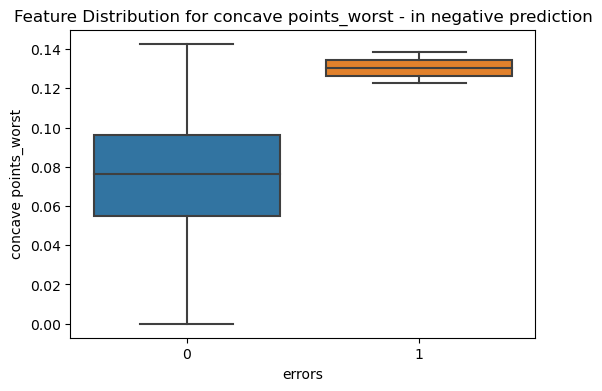

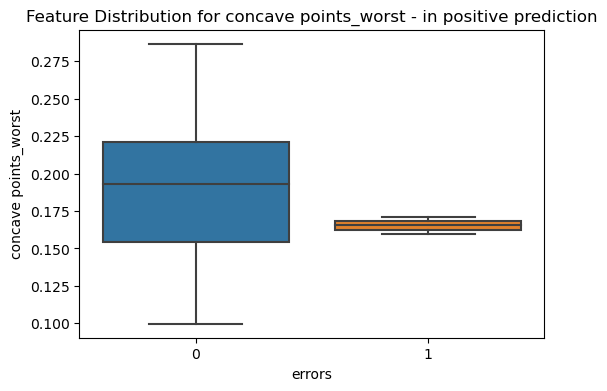

In [218]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=B, x='errors', y='concave points_worst')
plt.title(f'Feature Distribution for concave points_worst - in negative prediction')
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=N, x='errors', y='concave points_worst')
plt.title(f'Feature Distribution for concave points_worst - in positive prediction')
plt.show()

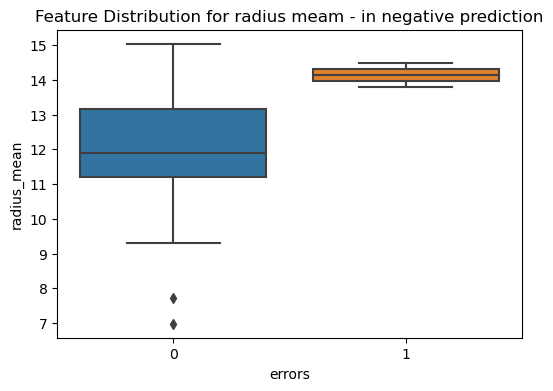

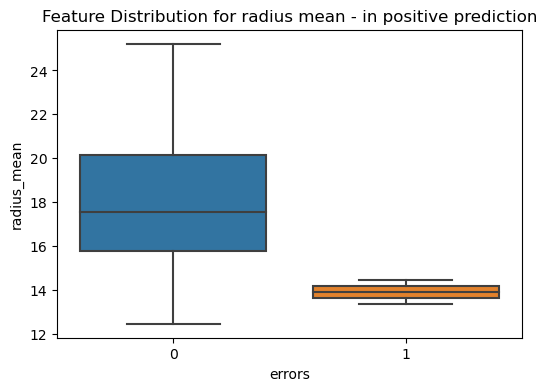

In [219]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=B, x='errors', y='radius_mean')
plt.title(f'Feature Distribution for radius meam - in negative prediction')
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=N, x='errors', y='radius_mean')
plt.title(f'Feature Distribution for radius mean - in positive prediction')
plt.show()

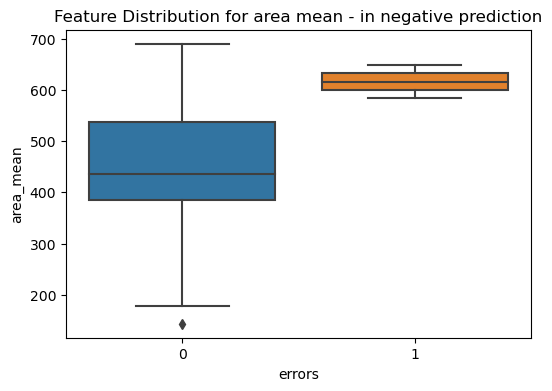

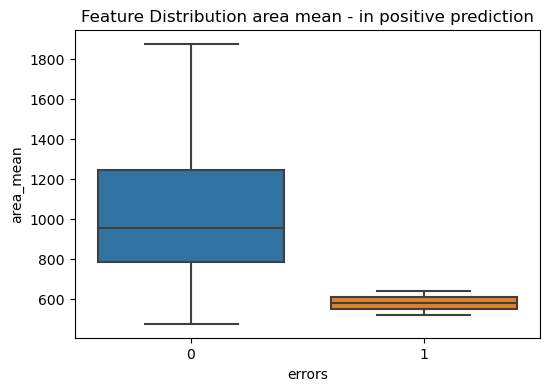

In [220]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=B, x='errors', y='area_mean')
plt.title(f'Feature Distribution for area mean - in negative prediction')
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=N, x='errors', y='area_mean')
plt.title(f'Feature Distribution area mean - in positive prediction')
plt.show()

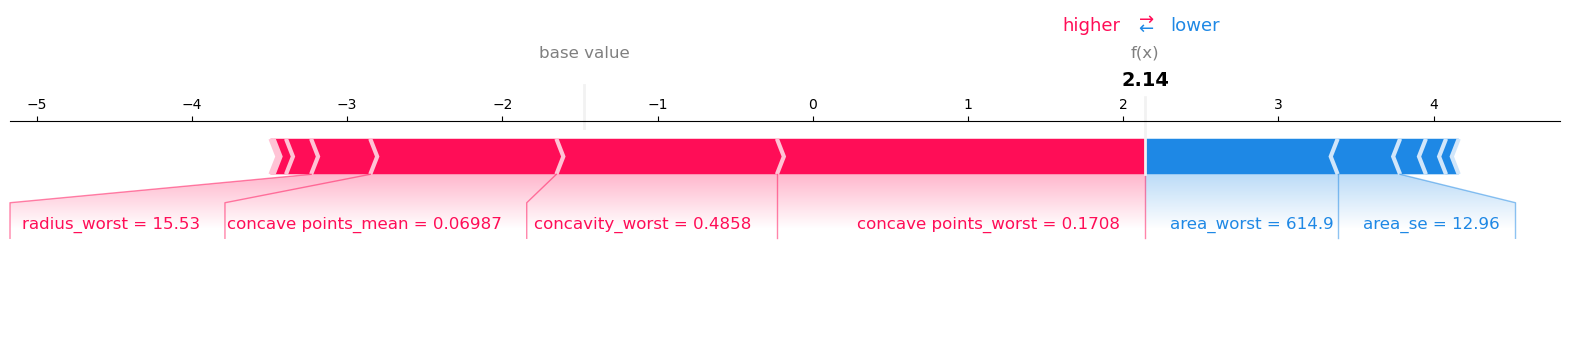

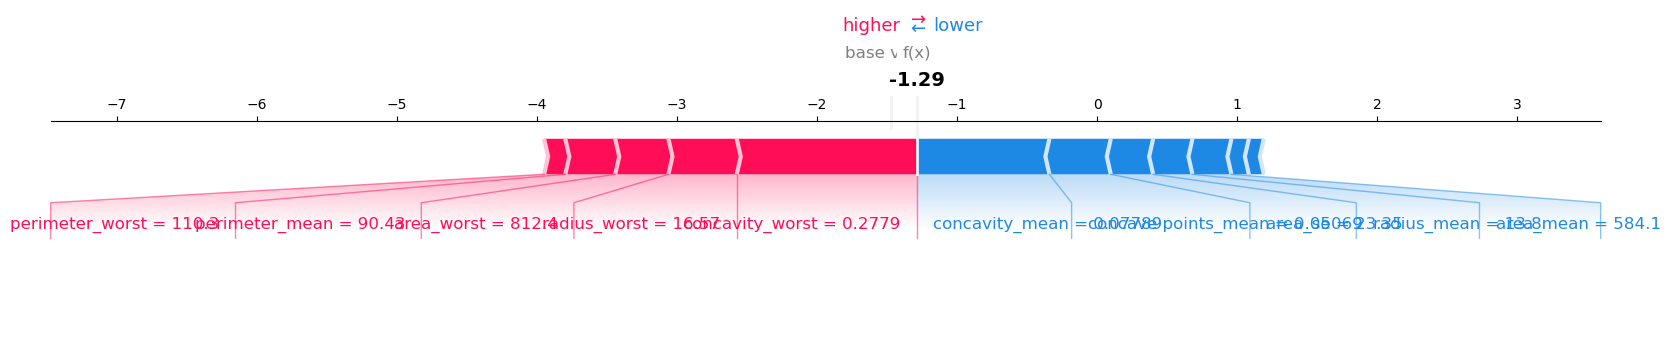

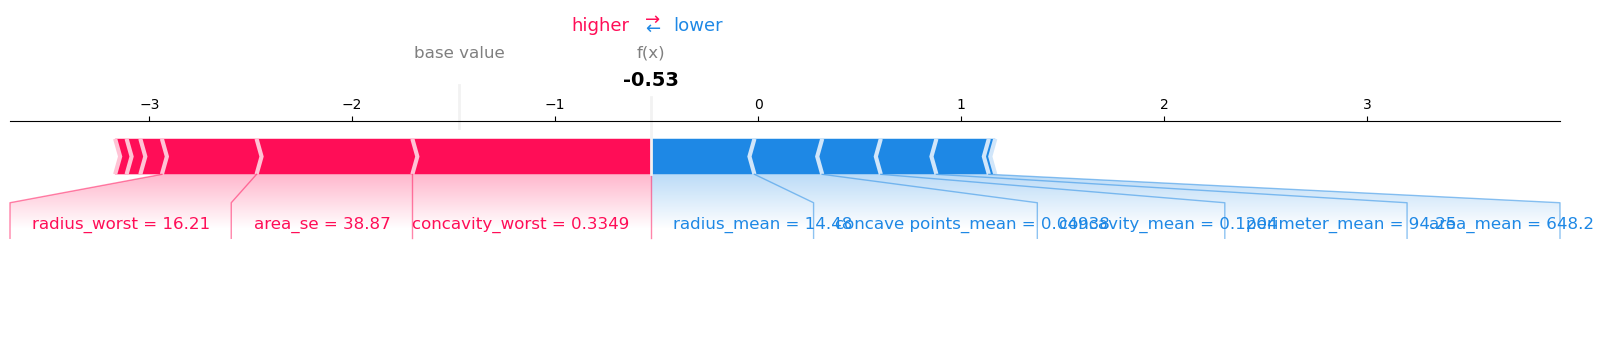

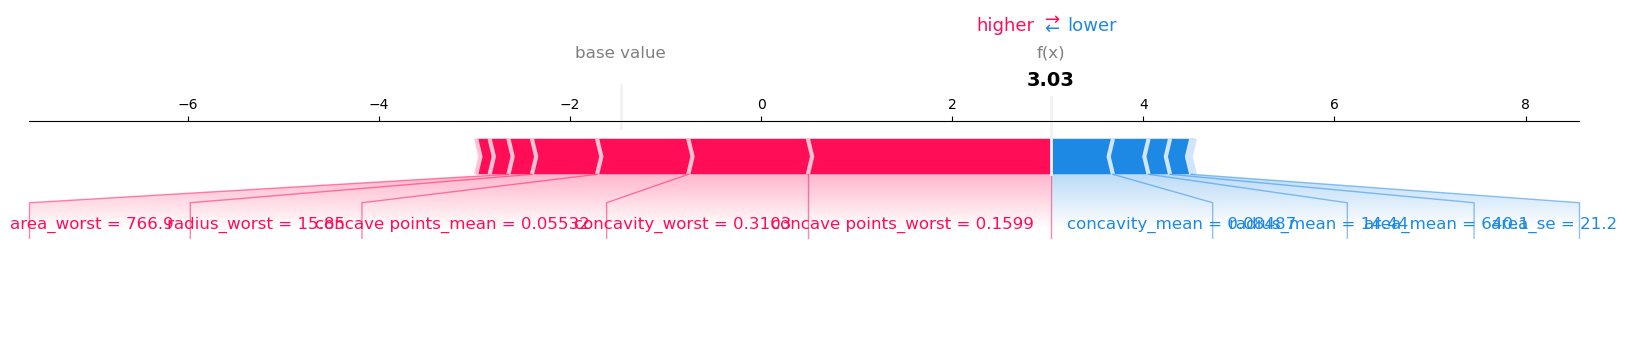

In [221]:
shap_values = explainer(X_test_selected)  # Assuming you've already set up SHAP
for i in errors.index:
    shap.plots.force(shap_values[i], matplotlib=True)

/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


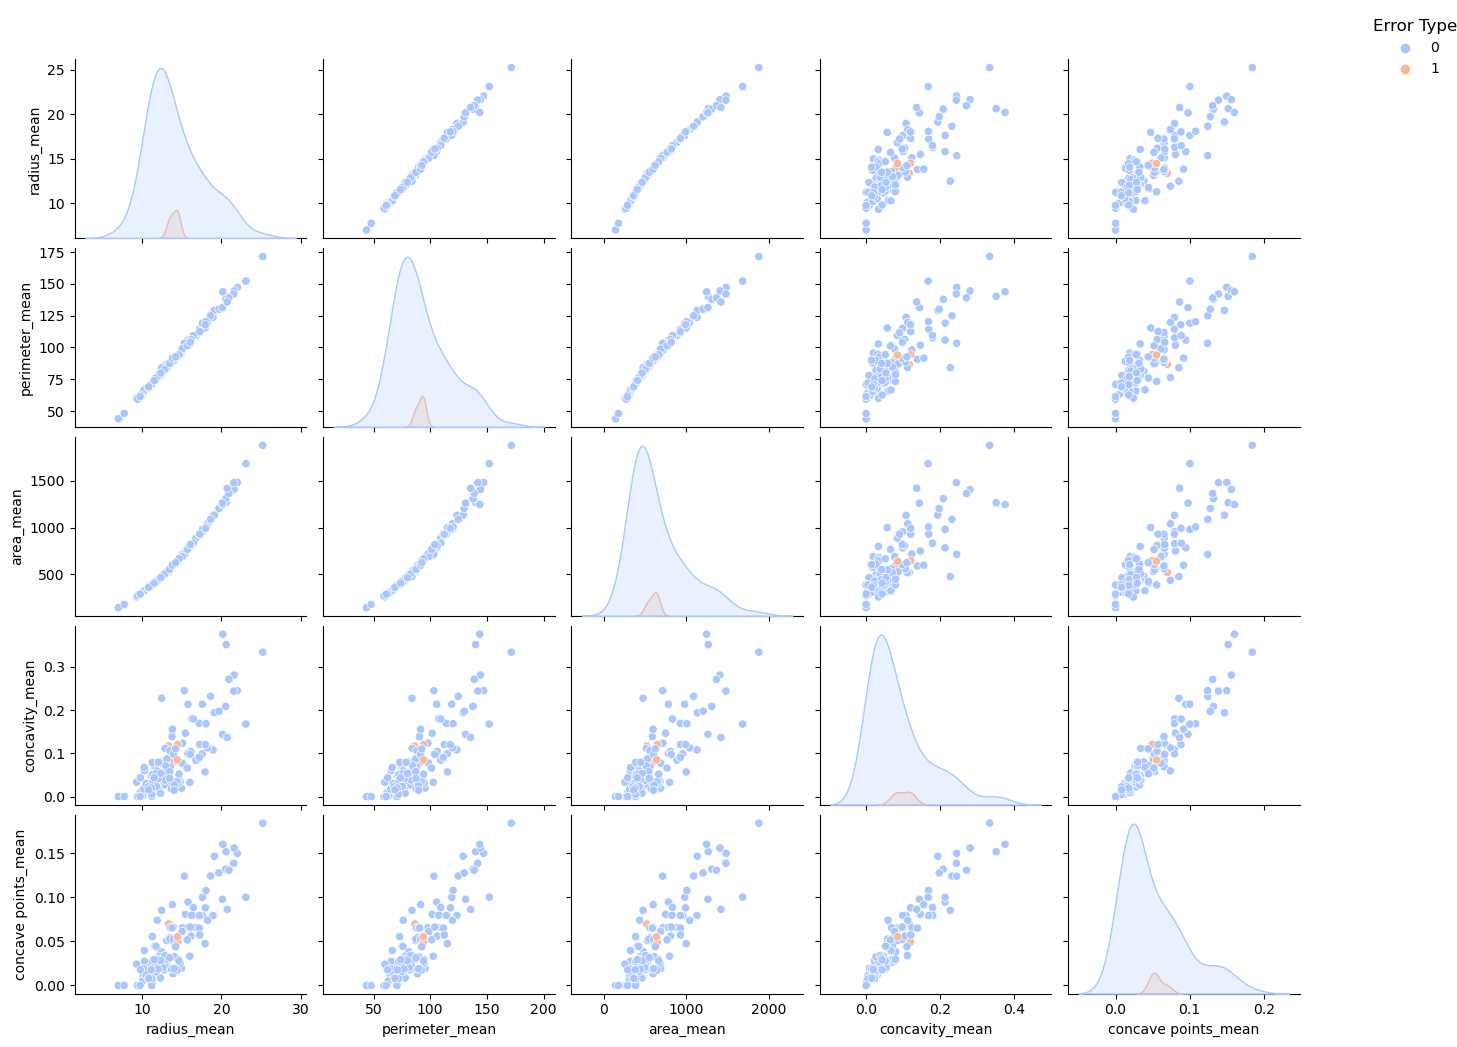

In [28]:
pairplot = sns.pairplot(data=X_test_with_labels, vars=selected_feature_names[:5], hue='errors', diag_kind='kde', palette='coolwarm')

# Adjust legend
pairplot._legend.set_title("Error Type")
pairplot._legend.set_bbox_to_anchor((1.05, 1))  # Move legend outside
#pairplot._legend.set_fontsize(10)  # Adjust legend font size
pairplot._legend.get_title().set_fontsize(12)  # Adjust title font size

# Adjust overall figure size
pairplot.fig.set_size_inches(14, 10)

plt.show()

In [20]:
y_pred_prob = xgb_model.predict_proba(X_test_selected)[:, 1]  # Probabilities for class 1
new_threshold = 0.2  # Example threshold
y_pred_adjusted = (y_pred_prob >= new_threshold).astype(int)

In [21]:
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_adjusted))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_adjusted))

roc_auc = roc_auc_score(y_test, y_pred_adjusted)
print(f"\nROC AUC Score: {roc_auc:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        71
           1       0.93      1.00      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.98      0.97       114
weighted avg       0.98      0.97      0.97       114


Confusion Matrix:
[[68  3]
 [ 0 43]]

ROC AUC Score: 0.9789


In [22]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_model, X_train_selected, y_train, cv=10, scoring='accuracy')
print(f"Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight", "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight", "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight", "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "c

Cross-Validation Accuracy: 0.9406 ± 0.0341


/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight", "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight", "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight", "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


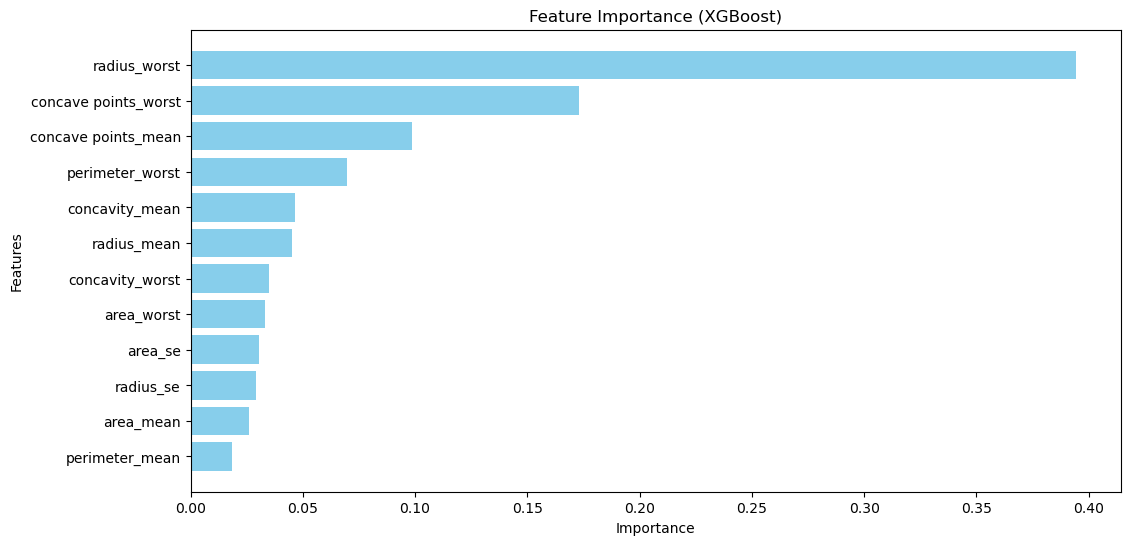

In [92]:
selected_feature_indices = selector.get_support(indices=True) 
selected_feature_names = X_test.columns[selected_feature_indices]
# Extract feature importance
feature_importance = pd.DataFrame({
    'Feature': selected_feature_names,  # Replace X.columns with actual feature names if needed
    'Importance': xgb_model.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # Reverse the order for better readability
plt.show()


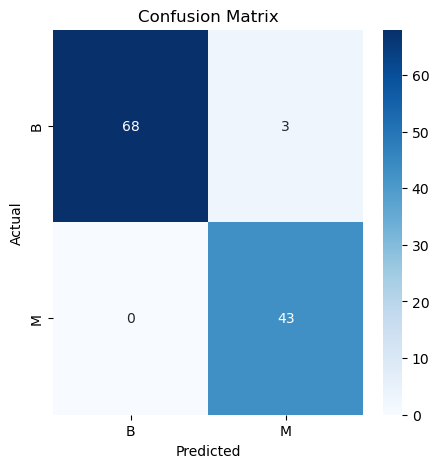

In [24]:
### Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_adjusted), annot=True, fmt='d', cmap='Blues', xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [95]:
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_feature_names)
# Combine X_test_selected_df and y_test for easier analysis
X_test_with_labels = pd.concat([X_test_selected_df.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

# Rename target column for clarity (optional)
X_test_with_labels.rename(columns={0: 'True Label'}, inplace=True)

# Add predictions and predicted probabilities
X_test_with_labels['Predicted Label'] = y_pred_adjusted
#X_test_with_labels['Predicted Probability'] = y_pred_prob_adjusted  # Assuming positive class at index 1

# Find misclassified samples
errors = X_test_with_labels[X_test_with_labels['diagnosis_numeric'] != X_test_with_labels['Predicted Label']]

print(errors)

     radius_mean  perimeter_mean  area_mean  concavity_mean  \
8          13.34           86.49      520.0         0.11690   
91         13.46           87.44      551.1         0.04201   
108        14.44           93.97      640.1         0.08487   

     concave points_mean  radius_se  area_se  radius_worst  perimeter_worst  \
8                0.06987     0.2860    12.96         15.53            96.66   
91               0.03152     0.1998    16.07         15.35           101.90   
108              0.05532     0.2406    21.20         15.85           108.60   

     area_worst  concavity_worst  concave points_worst  diagnosis_numeric  \
8         614.9           0.4858                0.1708                  0   
91        719.8           0.2654                0.1427                  0   
108       766.9           0.3103                0.1599                  0   

     Predicted Label  
8                  1  
91                 1  
108                1  


In [96]:
# Create 'errors' column: 1 if there is an error (i.e., 'diagnosis' != 'Predicted Label'), else 0
X_test_with_labels['errors'] = np.where(X_test_with_labels['diagnosis_numeric'] != X_test_with_labels['Predicted Label'], 1, 0)

# View the updated DataFrame
X_test_with_labels

,radius_mean,perimeter_mean,area_mean,concavity_mean,concave points_mean,radius_se,area_se,radius_worst,perimeter_worst,area_worst,concavity_worst,concave points_worst,diagnosis_numeric,Predicted Label,errors
0,12.47,81.09,481.9,0.08005,0.03821,0.3961,30.29,14.97,96.05,677.9,0.2671,0.10150,0,0,0
1,18.94,123.60,1130.0,0.10800,0.07951,0.7888,96.05,24.86,165.90,1866.0,0.2687,0.17890,1,1,0
2,15.46,101.70,748.9,0.14660,0.08087,0.4743,48.31,19.26,124.90,1156.0,0.3791,0.15140,1,1,0
3,12.40,81.47,467.8,0.07741,0.02799,0.1767,15.43,12.88,89.61,515.8,0.2403,0.07370,0,0,0
4,11.54,74.65,402.9,0.06737,0.02594,0.2784,20.86,12.26,78.78,457.8,0.1797,0.06918,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,14.64,94.21,666.0,0.05192,0.02791,0.2204,19.98,16.46,106.00,831.0,0.2437,0.07828,0,0,0
110,16.07,104.10,817.7,0.09769,0.06638,0.7474,79.25,19.77,128.80,1223.0,0.2829,0.15200,1,1,0
111,11.52,73.87,406.3,0.04328,0.02929,0.2562,18.62,12.65,80.88,491.8,0.1804,0.09608,0,0,0
112,14.22,92.55,623.9,0.11030,0.04408,0.3354,29.96,15.75,102.50,764.0,0.3064,0.08219,0,0,0


Instance 8 - Diagnosis: 0


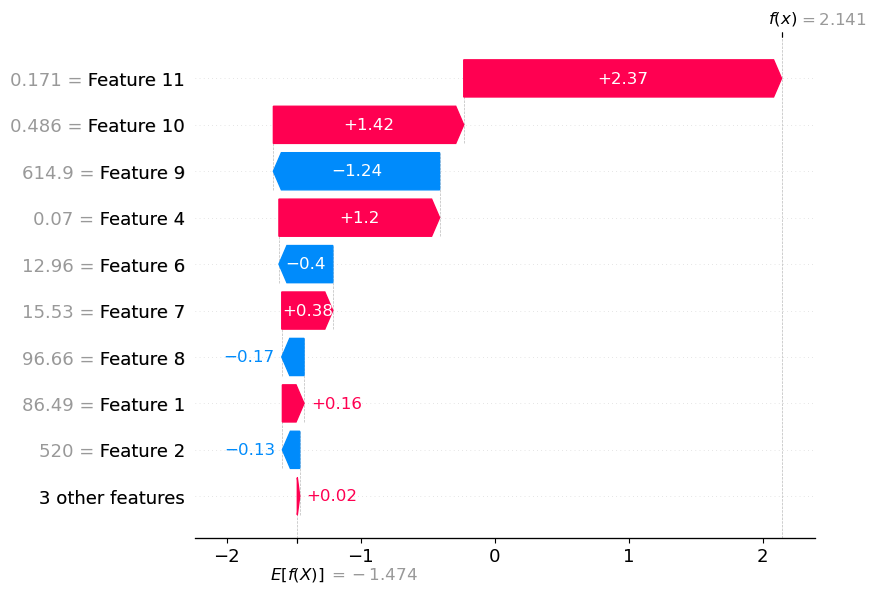

                 Feature  SHAP Value  Feature Value
11  concave points_worst    2.372324        0.17080
10       concavity_worst    1.420827        0.48580
4    concave points_mean    1.199252        0.06987
7           radius_worst    0.381106       15.53000
1         perimeter_mean    0.161715       86.49000
0            radius_mean    0.080109       13.34000
5              radius_se    0.019733        0.28600
3         concavity_mean   -0.081649        0.11690
2              area_mean   -0.129690      520.00000
8        perimeter_worst   -0.166343       96.66000
Instance 91 - Diagnosis: 0


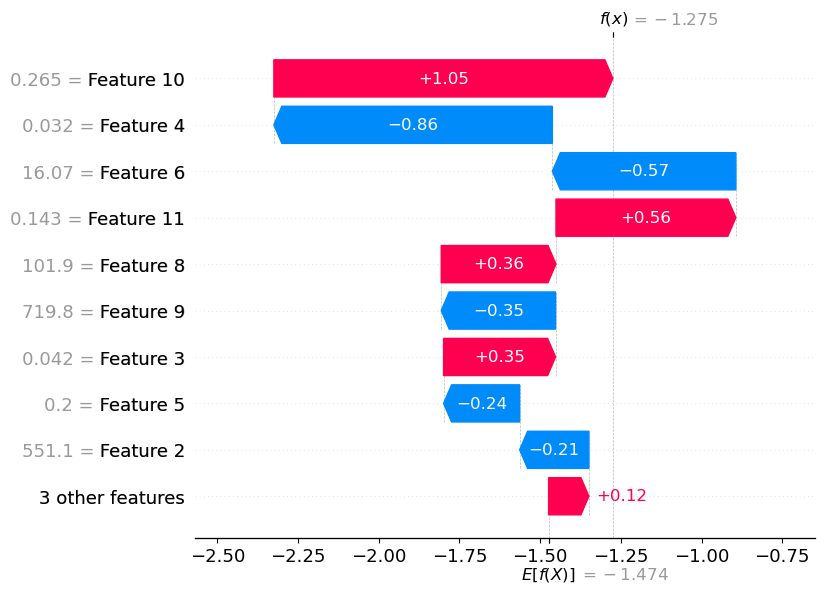

                 Feature  SHAP Value  Feature Value
10       concavity_worst    1.050381        0.26540
11  concave points_worst    0.557207        0.14270
8        perimeter_worst    0.355518      101.90000
3         concavity_mean    0.346961        0.04201
1         perimeter_mean    0.129749       87.44000
7           radius_worst    0.107113       15.35000
0            radius_mean   -0.112043       13.46000
2              area_mean   -0.214604      551.10000
5              radius_se   -0.235569        0.19980
9             area_worst   -0.354286      719.80000
Instance 108 - Diagnosis: 0


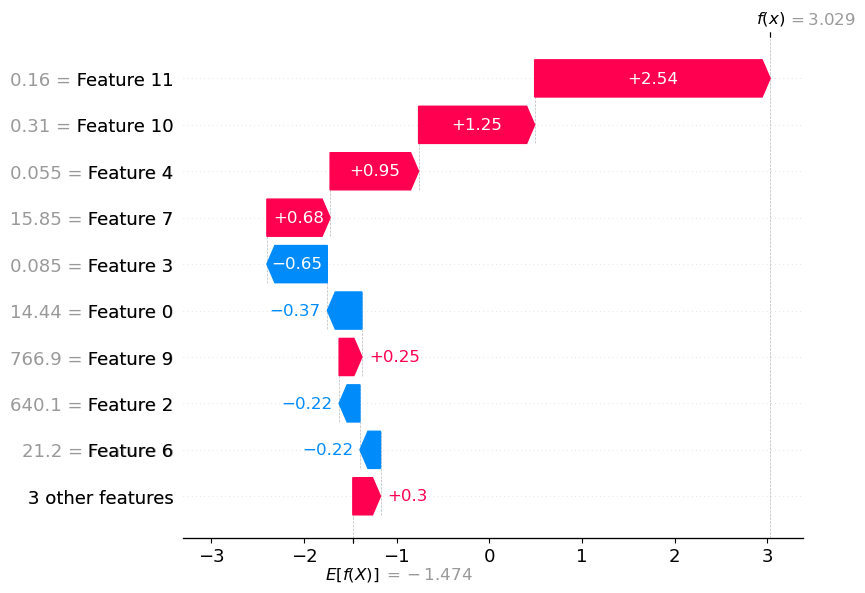

                 Feature  SHAP Value  Feature Value
11  concave points_worst    2.540803        0.15990
10       concavity_worst    1.252301        0.31030
4    concave points_mean    0.954725        0.05532
7           radius_worst    0.682111       15.85000
9             area_worst    0.246007      766.90000
1         perimeter_mean    0.196922       93.97000
8        perimeter_worst    0.140409      108.60000
5              radius_se   -0.038895        0.24060
6                area_se   -0.221594       21.20000
2              area_mean   -0.224875      640.10000


In [97]:
# Ensure X_test_selected is a DataFrame with feature names
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_feature_names)  # Replace `feature_names` with your list
# Iterate over the first 5 errors
for i in errors.index[:5]:  
    print(f"Instance {i} - Diagnosis: {y_test.iloc[i]}")

    # Waterfall plot for the specific instance
    shap.plots.waterfall(shap_values[i])

    # Get feature names for this instance and their SHAP values
    feature_importance = pd.DataFrame({
        "Feature": X_test_selected.columns,
        "SHAP Value": shap_values[i].values,  # SHAP values for instance i
        "Feature Value": X_test_selected.iloc[i].values  # Actual feature values
    })

    # Display feature importance sorted by SHAP value
    print(feature_importance.sort_values(by="SHAP Value", ascending=False).head(10))  # Top 10 features

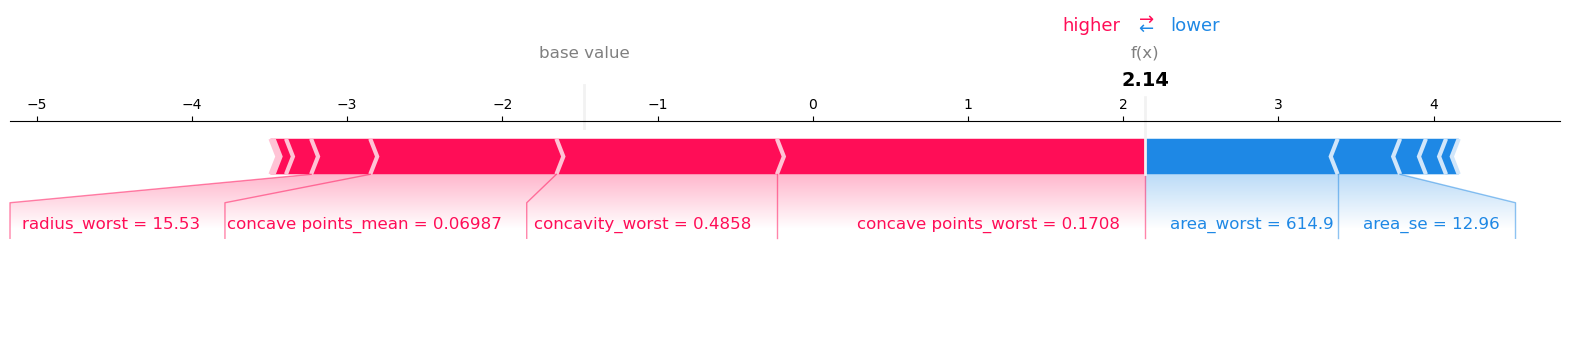

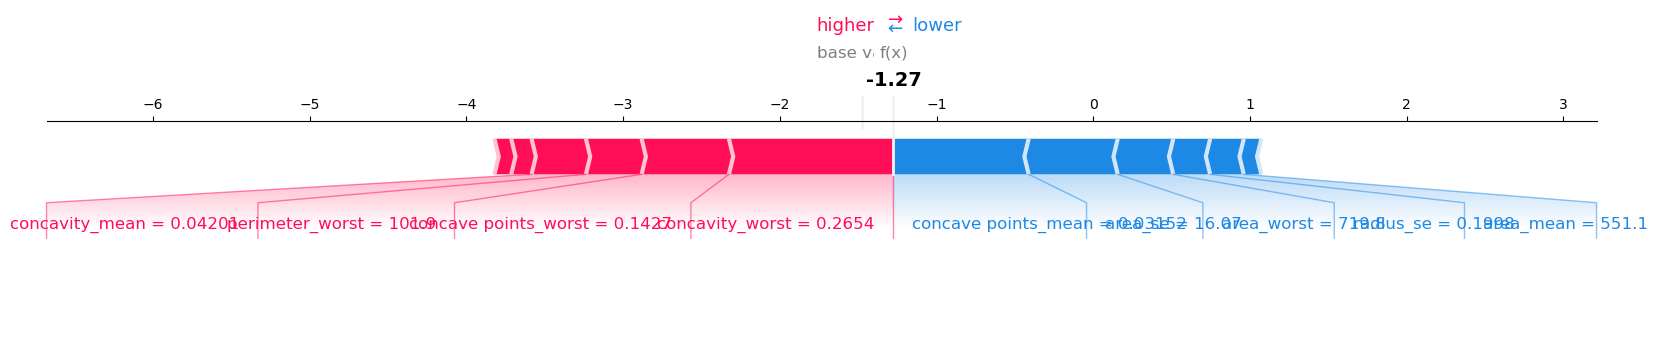

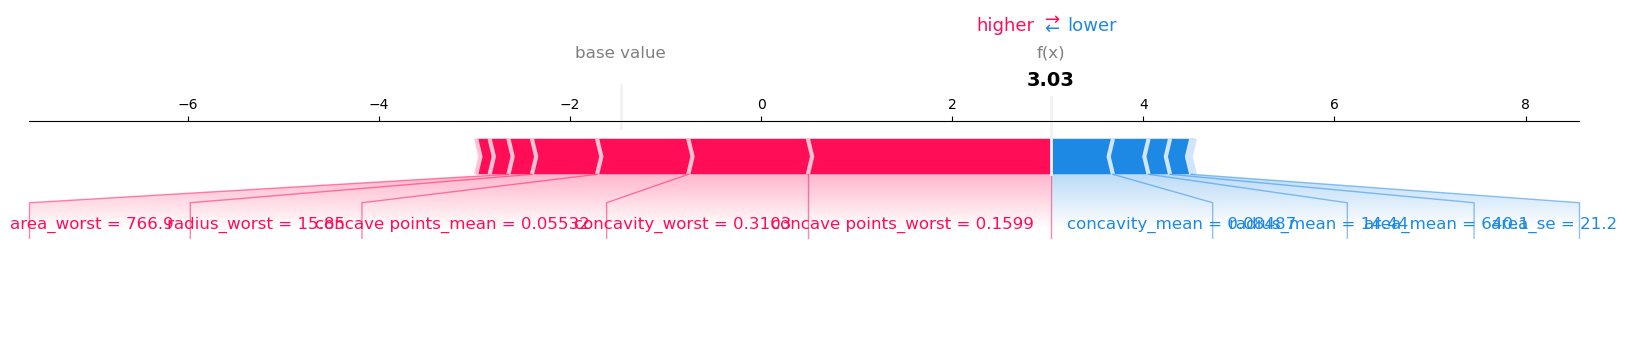

In [98]:
shap_values = explainer(X_test_selected)  # Assuming you've already set up SHAP
for i in errors.index:
    shap.plots.force(shap_values[i], matplotlib=True)